1) Initializing the notebook with all necessary parameters to use the model

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting. If you don’t specify a bucket, SageMaker SDK will create a default bucket following a pre-defined naming convention in the same region.

- The IAM role ARN used to give SageMaker access to your data. It can be fetched using the get_execution_role method from sagemaker python SDK.

- Also using automatic model tuning within this notebook to find the best version of the model by running many parallel jobs over a set range of hyperparameters.
- Have the ability to change the range of all the parameter to you can choose a combination of values that optimize the model to get the accuracy you desire.

In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sagemaker
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from random import shuffle
import multiprocessing
from multiprocessing import Pool
import csv
import json
import nltk

sess = sagemaker.Session()

nltk.download("punkt")

role = get_execution_role()
print(role)
bucket = "a202990-mapping-osr-accounts-s3-bucket"
print(bucket)
prefix = "Data10kCells"


arn:aws:iam::367379483300:role/service-role/AmazonSageMaker-ExecutionRole-20220712T124620
a202990-mapping-osr-accounts-s3-bucket


[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


- Retreive the data from the S3 bucket where it is kept.

In [2]:
dataset = pd.read_csv('s3://' + bucket + '/' + prefix + '/' + 'ActualDataWithoutExtraColumns.csv')

- Get all unique category names from the data

In [3]:
categories = dataset["NominalCategoryCodename"].unique()
print(categories)
with open("classes.txt", 'w') as out:
    for n in categories:
        out.write(n + '\n')

['NCA 3 1 2 5'
 'iXBRL DPL (cost of sales) other repairs and maintenance costs'
 'NCA 3 2 2 5' ... 'iXBRL DPL (distribution) other staff costs, directors'
 'NCA 7 3 2 2' 'Sales 1 UK']


- Labels each category name with a number for the model to mathematically calculate where the inputs go

In [1]:
index_to_label = {}
with open("classes.txt") as f:
   for i, label in enumerate(f.readlines()):
        index_to_label[str(i + 1)] = label.strip()
    
#print(index_to_label)

2) Creating a dictionary for all the category names
- What dataset.replace({parameter1 : dict_map}) does is that any input names that have the same name as the category aren't labeled as 1,1 but rather 1, (the name of the input).

3) Using the NumPy function split() to create a three different datasets from the data. 
    - 70% will be used for training, 15% for testing and 15% for test validation
    - Will create csv files that will contain this information to parse later on

In [5]:
dict_map = {v: k for k, v in index_to_label.items()}
#data = dataset.replace(dict_map)
data = dataset.replace({"NominalCategoryCodename": dict_map})
data = data.rename(columns = data.iloc[0]).drop(data.index[0])
#data = data.rename(columns = data.iloc[0])
#data.iloc[1] = "Name"
#data = data.rename(columns = data.iloc[1])

#Train Test Split
train_data, validation_data, test_data = np.split(data.sample(frac = 1, random_state = 2000), [int(.7 * len(data)), int(.85 * len(data))])
train_data.to_csv("train.csv", header = True, index = False)
validation_data.to_csv('test.csv', header = True, index = False)


data

,1,Goodwill amortisation on foreign exchange movements
1,2,iXBRL DPL (cost of sales) other repairs and ma...
2,3,"Trademarks, patents and licenses amortisation ..."
3,4,Motor vehicles depreciation eliminated on disp...
4,5,Surplus or deficit on changes in fair value of...
5,6,iXBRL DPL F2 gain or loss on negative goodwill...
...,...,...
9251,1153,Audit of the financial statements
9252,1154,iXBRL DPL (administrative) pension costs defin...
9253,1155,"iXBRL DPL (distribution) other staff costs, di..."
9254,1156,Other depreciation charge for year


In [6]:
dataset2 = pd.read_csv('trainwithoutrow[1]10kcells.csv')

In [7]:
print(dataset2['1'])

0       218
1       478
2       409
3       350
4       186
       ... 
6473    358
6474    889
6475    819
6476     82
6477    864
Name: 1, Length: 6478, dtype: int64


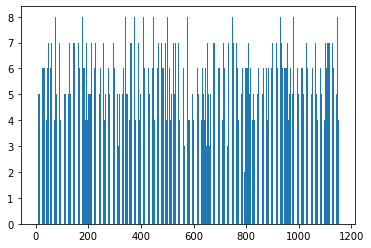

In [9]:
#Shows us the frequency of each category within the Train.csv file
x = plt.hist(dataset2['1'],bins = 2000)
plt.show(x)
#for s in a:
  #  if dataset["Names"][s] != 0
        

4) BlazingText expects a single preprocessed text file with space separated tokens and each line of the file should contain a single sentence and the corresponding label(s) prefixed by “_*label_*”.

- We need to preprocess the training data into space separated tokenized text format which can be consumed by BlazingText algorithm. Also, as mentioned previously, the class label(s) should be prefixed with __label__ and it should be present in the same line along with the original sentence. We’ll use nltk library to tokenize the input sentences from the dataset.

In [10]:
def transform_instance(row):
    cur_row = []
    label = "__label__" + index_to_label[row[0]]  # Prefix the index-ed label with __label__
    cur_row.append(label)
    cur_row.extend(nltk.word_tokenize(row[1].lower()))
    #cur_row.extend(nltk.word_tokenize(row[2].lower()))
    return cur_row

The transform_instance will be applied to each data instance in parallel using python’s multiprocessing module

In [11]:
def preprocess(input_file, output_file, keep = 1):
    all_rows = []
    with open(input_file, "r") as csvinfile:
        csv_reader = csv.reader(csvinfile, delimiter=",")
        for row in csv_reader:
            all_rows.append(row)
    shuffle(all_rows)
    all_rows = all_rows[: int(keep * len(all_rows))]
    pool = Pool(processes=multiprocessing.cpu_count())
    transformed_rows = pool.map(transform_instance, all_rows)
    pool.close()
    pool.join()

    with open(output_file, "w") as csvoutfile:
        csv_writer = csv.writer(csvoutfile, delimiter=" ", lineterminator="\n")
        csv_writer.writerows(transformed_rows)

In [12]:
%%time

# Preparing the training dataset

# Since preprocessing the whole dataset might take a couple of mintutes,
# we keep 20% of the training dataset for this demo.
# Set keep to 1 if you want to use the complete dataset
preprocess("train.csv", "categories.train", keep=1)

# Preparing the validation dataset
preprocess("test.csv", "categories.validation")

CPU times: user 133 ms, sys: 101 ms, total: 233 ms
Wall time: 914 ms


In [13]:
%%time

train_channel = prefix + "/train"
validation_channel = prefix + "/validation"

sess.upload_data(path="categories.train", bucket=bucket, key_prefix=train_channel)
sess.upload_data(path="categories.validation", bucket=bucket, key_prefix=validation_channel)

s3_train_data = "s3://{}/{}".format(bucket, train_channel)
s3_validation_data = "s3://{}/{}".format(bucket, validation_channel)

CPU times: user 50.3 ms, sys: 11 ms, total: 61.4 ms
Wall time: 357 ms


In [14]:
s3_output_location = "s3://{}/{}/output".format(bucket, prefix)

5) Training the BlazingText model for Supervised Text Classification and settings up Hyperparemeter Tuning Job

- Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a sageMaker.estimator.Estimator object. This estimator will launch the training job.

In [15]:
region_name = boto3.Session().region_name

In [16]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "1")
print("Using SageMaker BlazingText container: {} ({})".format(container, region_name))

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:1 (us-east-1)


6) Now, let’s define the SageMaker Estimator with resource configurations and hyperparameters to train Text Classification on the  dataset, using “supervised” mode on a ml.c4.4xlarge instance.

- Refer to BlazingText Hyperparameters in the Amazon SageMaker documentation for the complete list of hyperparameters.


In [17]:
estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.4xlarge",
    volume_size=30,
    max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    hyperparameters={
        "mode": "supervised",
        "epochs": 25,
        "min_count": 2,
        #"learning_rate": 0.05,
        #"vector_dim": 10,
        "early_stopping": True,
        "patience": 4,
        "min_epochs": 5,
        "word_ngrams": 1,
    },
)

7) Setting up Hyperparameter tuning here
- Setting our hyperparameter ranges here. If you want to improve accuracy after running the model, you can change the ranged here to create a larger range of testing. 
- Note it will take much longer with a larger range


In [18]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.05, 0.15),
    "vector_dim": IntegerParameter(32, 300),
}

In [19]:
objective_metric_name = "validation:accuracy"
objective_type = "Maximize"

8) Create a HyperparameterTuner object, to which we pass:

-  The BlazingText estimator we created above
-  Our hyperparameter ranges
-  Objective metric name and definition
-  Tuning resource configurations such as Number of training jobs to run in total and how many training jobs can be run in parallel.

In [20]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=6,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

9) Now that the hyper-parameters are setup, let us prepare the connection between our data channels and the algorithm. To do this, we need to create the sagemaker.session.s3_input objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.

In [21]:
train_data = sagemaker.inputs.TrainingInput(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_data,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
data_channels = {"train": train_data, "validation": validation_data}

- We have our Estimator object, we have set the hyper-parameters for this object and we have our data channels linked with the algorithm. The only remaining thing to do is to train the algorithm. The following command will train the algorithm. Training the algorithm involves a few steps. Firstly, the instance that we requested while creating the Estimator classes is provisioned and is setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take some time, depending on the size of the data. Therefore it might be a few minutes before we start getting training logs for our training jobs. The data logs will also print out Accuracy on the validation data for every epoch after training job has executed min_epochs. This metric is a proxy for the quality of the algorithm.

- Once the job has finished a “Job complete” message will be printed. The trained model can be found in the S3 bucket that was setup as output_path in the estimator.

10) Launch the Hyperparameter tuning job

- Use the fit() method to launch the job and use the SageMaker Console to keep track of progress

In [22]:
%%time

tuner.fit(inputs=data_channels, logs=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.............................................................................................................!
CPU times: user 634 ms, sys: 47.8 ms, total: 682 ms
Wall time: 9min 12s


- Analyze + Track The tuning Job Results and Progress

In [23]:
sm_client = boto3.Session().client("sagemaker")

tuning_job_name = tuner.latest_tuning_job.name
tuning_job_name

'blazingtext-220811-1702'

In [24]:
tuning_job_result = sm_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

status = tuning_job_result["HyperParameterTuningJobStatus"]
if status != "Completed":
    print("Reminder: the tuning job has not been completed.")

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" % job_count)

is_minimize = (
    tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]["Type"]
    != "Maximize"
)
objective_name = tuning_job_result["HyperParameterTuningJobConfig"][
    "HyperParameterTuningJobObjective"
]["MetricName"]

6 training jobs have completed


In [25]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob", None):
    print("Best model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2022, 8, 11, 17, 8, 57, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:accuracy',
                                                 'Value': 0.875},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2022, 8, 11, 17, 11, 37, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:367379483300:training-job/blazingtext-220811-1702-006-04edb2c2',
 'TrainingJobName': 'blazingtext-220811-1702-006-04edb2c2',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2022, 8, 11, 17, 10, 50, tzinfo=tzlocal()),
 'TunedHyperParameters': {'learning_rate': '0.15', 'vector_dim': '32'}}


- Get the results and make it a DataFrame

In [26]:
import pandas as pd

tuner_analytics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner_analytics.dataframe()

if len(full_df) > 0:
    df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df) > 0:
        df = df.sort_values("FinalObjectiveValue", ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest": min(df["FinalObjectiveValue"]), "highest": max(df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", -1)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

df

Number of training jobs with valid objective: 6
{'lowest': 0.0625, 'highest': 0.875}


/tmp/ipykernel_9256/3842159511.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)  # Don't truncate TrainingJobName


,learning_rate,vector_dim,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.150000,32.0,blazingtext-220811-1702-006-04edb2c2,Completed,0.8750,2022-08-11 17:10:50+00:00,2022-08-11 17:11:37+00:00,47.0
3,0.142609,104.0,blazingtext-220811-1702-003-8deb94bb,Completed,0.8125,2022-08-11 17:07:34+00:00,2022-08-11 17:08:26+00:00,52.0
1,0.129399,95.0,blazingtext-220811-1702-005-8da03655,Completed,0.6875,2022-08-11 17:10:41+00:00,2022-08-11 17:11:33+00:00,52.0
4,0.129569,69.0,blazingtext-220811-1702-002-75fc8cd0,Completed,0.6875,2022-08-11 17:04:43+00:00,2022-08-11 17:05:30+00:00,47.0
5,0.115211,34.0,blazingtext-220811-1702-001-a41b5be6,Completed,0.5625,2022-08-11 17:04:34+00:00,2022-08-11 17:05:30+00:00,56.0
2,0.084502,257.0,blazingtext-220811-1702-004-e6e6d455,Completed,0.0625,2022-08-11 17:07:41+00:00,2022-08-11 17:08:33+00:00,52.0


11) Hosting / Inference the best trained model

- Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don’t have to host on the same type of instance that we used to train. Because instance endpoints will be up and running for long, it’s advisable to choose a cheaper instance for inference.

In [27]:
from sagemaker.serializers import JSONSerializer

text_classifier = tuner.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=JSONSerializer()
)


2022-08-11 17:11:37 Starting - Preparing the instances for training
2022-08-11 17:11:37 Downloading - Downloading input data
2022-08-11 17:11:37 Training - Training image download completed. Training in progress.
2022-08-11 17:11:37 Uploading - Uploading generated training model
2022-08-11 17:11:37 Completed - Training job completed
----------!

- BlazingText supports application/json as the content-type for inference. The payload should contain a list of sentences with the key as “instances” while being passed to the endpoint.

- By default, the model will return only one prediction, the one with the highest probability. For retrieving the top k predictions, you can set k in the configuration as shown below:

In [44]:
sentences = {
    #"Vehicle Costs for Crash"
    #"Current Liabilities"
    #"Financial Contracts"
    #"Other country Money"
    #"Government" 
    #"iXBRL DPL F2 gain or loss on negative goodwill/bargain purchases released to income"
    #"Contract liabilities"
    #"Miscellaneous other operating income"
    #"Current portion of long term lease liabilities"
    #"iXBRL DPL (cost of sales) wages/salaries"
    #"Gain or loss on disposal of property, plant and equipment"
    #"Deferred tax on post-retirement healthcare scheme 1 asset/liability"
    #"Balance"
    'Profit/loss before tax' #50% probability but 100% accuracy
    #'Current assets' #54% probability with 100% accuracy
    #'Other current financial liabilities' # 53% probability with 100% accuracy
    
    
    ##Major Problem with NLP is that it can't understand accounting terminology like a human can unless we train it over and over again
    
    
}

tokenized_sentences = [" ".join(nltk.word_tokenize(sent)) for sent in sentences]

payload = {"instances": tokenized_sentences}

response = text_classifier.predict(payload)

predictions = json.loads(response)

print(json.dumps(predictions, indent=2))
#print("prob: 100%")

#runtime_client = boto3.client("runtime.sagemaker", region_name = region)

[
  {
    "label": [
      "__label__PBT"
    ],
    "prob": [
      0.4981212615966797
    ]
  }
]


12) Delete Endpoints

- Finally, we should delete the endpoint before we close the notebook if we don’t need to keep the endpoint running for serving realtime predictions.

In [28]:
sess.delete_endpoint(text_classifier.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
